In [2]:
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore

In [3]:
def max_abs_scale(series):
    return series / series.abs().max()

image_order = ["500b", "100Kb", "256Kb", "1Mb", "15Mb"]

dfe = pd.read_csv("energy.csv")

dfm = pd.read_csv("result.csv")  


Energy data frame pre-processing 

In [4]:
energy_features = [
    "cpu0_package_joules",
    "cpu1_package_joules"
]

# dfte : Data Frame Total Energy 
dfte = (
    dfe.copy()
    .assign(
        energy=lambda df: df[energy_features].sum(axis=1)
    )
    .groupby(['model', 'image'], as_index=False)['energy']
    .agg(std_energy='std', mean_energys='mean')
    .assign(
        mean_energys=lambda df: df.groupby('image')['mean_energys'].transform(max_abs_scale),
        image=lambda df: pd.Categorical(df['image'], categories=image_order, ordered=True),
    )
    .sort_values(['model', 'image'])
)

libraries = dfte['model'].unique() # Define the libraries and image sizes
sizes = dfte['image'].unique()

# dftt.head()

In [6]:
bar_width = 0.15
sizes = dfte['image'].unique()
positions = np.arange(len(sizes))
libraries = dfte['model'].unique()  


color_mapping = {
    "resnet34": "#f0e68c",
    "resnet152": "#27ae60",
    "resnet18": "#17becf",
    "resnet50": "#ff7f0e"
}

def bar_ax_style(ax, ylabel):
     
    ax.set_ylabel(ylabel , fontsize=10, labelpad=12)  # Set the labels and title
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3)
    
    ax.set_xticks(positions + bar_width * (len(libraries) - 1) / 2)  # Set the x-ticks and labels
    ax.set_xticklabels(sizes)
    
    ax.legend(
        bbox_to_anchor=(1, 0.8), 
        loc='upper left', 
        ncols = 1, 
        frameon=False, 
        fontsize=9
    )
    
    return ax

Energy

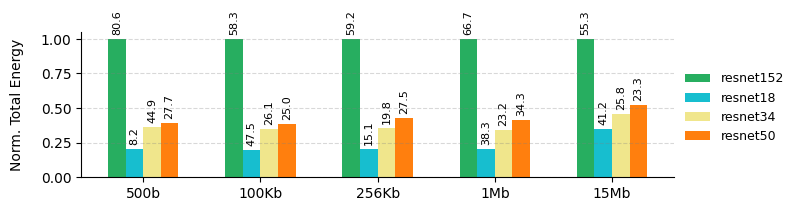

In [7]:
fig, ax = plt.subplots(figsize=(8, 2.2))  

# Plot each image size
for i, library in enumerate(libraries):
    
    subset = dfte[dfte['model'] == library]
    bar_positions = np.arange(len(sizes)) + i * bar_width
    bars = ax.bar(
        bar_positions, 
        subset['mean_energys'], 
        width=bar_width, 
        label=library, 
        color=color_mapping[library]
    )

    for bar, std in zip(bars, subset['std_energy']):
        height = bar.get_height()
        ax.annotate(
            f'{std:.1f}',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom',
            fontsize=8, rotation=90
        )

ax = bar_ax_style(ax, "Norm. Total Energy")

# plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Metric data frame pre-processing 

In [ ]:
dfm = pd.read_csv("result.csv")  

dfm['image'] = dfm['image'].str.replace('.JPEG', '', case=False)

times_features = [
    "prediction_time",
    "download_time",
    "model_load_time"
]

# dfms : Data Frame Memory Space
dfms = (
    dfm.copy()
    .groupby(['model', 'image'], as_index=False)['model_size']
    .agg(std_size='std', mean_size='mean')
    .assign(
        normalized_model_size=lambda df: df.groupby('image')['mean_size'].transform(max_abs_scale),
        image=lambda df: pd.Categorical(df['image'], categories=image_order, ordered=True),
    )
    .sort_values(['model', 'image'])
)

# dfp : Data Frame Probality 
dfp = (
    dfm.copy()
    .groupby(['model', 'image'], as_index = False)['prob']
    .agg(std_size='std', mean_prob='mean')
    .assign(
        image=lambda df: pd.Categorical(df['image'], categories=image_order, ordered=True),
    )
    .sort_values(['model', 'image'])
)

# dftt : Data Frame Total Time 
dftt = (
    dfm.copy()
    .assign(
        total_time=lambda df: df[times_features].sum(axis=1)
    )
    .groupby(['model', 'image'], as_index=False)['total_time']
    .agg(std_total_time='std', mean_time='mean')
    .assign(
        normalized_total_time=lambda df: df.groupby('image')['mean_time'].transform(max_abs_scale),
        image=lambda df: pd.Categorical(df['image'], categories=image_order, ordered=True),
    )
    .sort_values(['model', 'image'])
)
 
# libraries = dfct['library'].unique()  
# image_sizes = dfct['image'].unique()

# dfct.head()


Memory Size

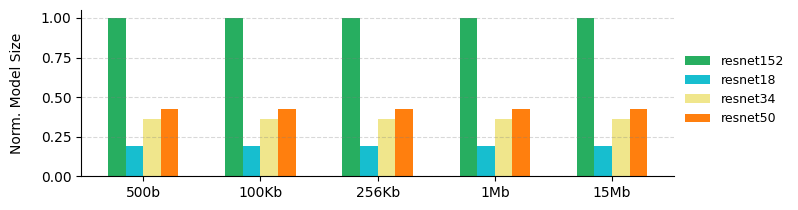

In [14]:
fig, ax = plt.subplots(figsize=(8, 2.2)) # Create a figure and axis

positions = np.arange(len(sizes))  

# Plot each image size
for i, library in enumerate(libraries):
    subset = dfms[dfms['model'] == library]
    bar_positions = positions + i * bar_width
    ax.bar(bar_positions, subset['normalized_model_size'], width=bar_width, label=library, color=color_mapping[library])

ax = bar_ax_style(ax, "Norm. Model Size")

# plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Prediction Probality

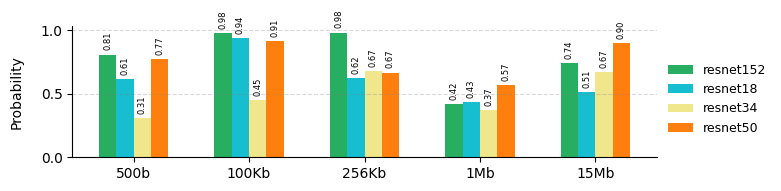

In [21]:
fig, ax = plt.subplots(figsize=(8, 2))

# Plot each image size
for i, library in enumerate(libraries):
    subset = dfp[dfp['model'] == library]
    bar_positions = positions + i * bar_width
    bars = ax.bar(bar_positions, subset['mean_prob'], width=bar_width, label=library, color=color_mapping[library])
    
    for bar, prop in zip(bars, subset['mean_prob']):
        height = bar.get_height()
        ax.annotate(f'{prop:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=6, rotation=90)

ax = bar_ax_style(ax, "Probability")

plt.tight_layout()
plt.show()


Total Time

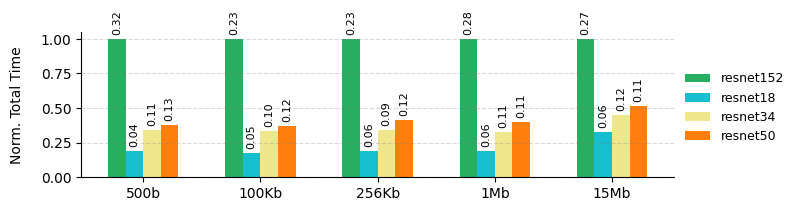

In [28]:
fig, ax = plt.subplots(figsize=(8, 2.2))

positions = np.arange(len(sizes))

for i, library in enumerate(libraries):
    subset = dftt[dftt['model'] == library]
    bar_positions = positions + i * bar_width
    bars = ax.bar(bar_positions, subset['normalized_total_time'], width=bar_width, label=library, color=color_mapping[library])

    for bar, std in zip(bars, subset['std_total_time']):
        height = bar.get_height()
        ax.annotate(f'{std:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8, rotation=90)

ax = bar_ax_style(ax, "Norm. Total Time")

plt.tight_layout()
plt.show()